In [36]:
from keras.layers import Activation
from keras.layers import AveragePooling2D
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.models import Model
from keras import initializers
from keras.optimizers import SGD, Adam
from keras.models import load_model
from tensorflow.examples.tutorials.mnist import input_data
import sklearn.utils
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
from PIL import Image

%matplotlib inline

In [93]:
def build_model(weights_path=None, input_shape=(64, 64, 1), n_output=None):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(n_output))
    model.add(Activation('softmax'))

    optimizer = Adam(lr=1e-4)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [73]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [74]:
x, y = mnist.train.next_batch(60000)
x, y = sklearn.utils.shuffle(x, y, random_state=0)

In [75]:
print(x.shape)
x = x.reshape((x.shape[0], 28, 28, 1))
print(x.shape)

(60000, 784)
(60000, 28, 28, 1)


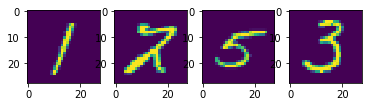

In [76]:
fig, axes = plt.subplots(1, 4)
for i in range(4):
    img_index = int(random.random()*60000)
    axes[i].imshow(x[img_index, :, :, 0])

In [95]:
model = build_model(input_shape=(28, 28, 1), n_output=10)

In [100]:
model.fit(x, y, epochs=10, batch_size=128)

Epoch 1/3
60000/60000 [==============================] - 59s - loss: 0.2257 - acc: 0.9337    
Epoch 2/3
60000/60000 [==============================] - 54s - loss: 0.2066 - acc: 0.9389    
Epoch 3/3
60000/60000 [==============================] - 50s - loss: 0.1917 - acc: 0.9430    


In [101]:
model.save("mnist_cnn.h5")

In [42]:
# model = load_model("mnist_cnn.h5")

In [43]:
x_test, y_test = mnist.test.next_batch(10000)
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [65]:
def array_to_sprite_atlas(image_array, num_sprites_x, num_sprites_y):
    "Takes an array of images of shape (num_images, img_width, img_height) and splices them together to form a big ass mosaic (sprite atlas)."
    # Mnist arrays are in 0-1 range, PIL needs 0-255
    image_array = image_array * 255
    image_width, image_height = image_array.shape[1], image_array.shape[2]
    atlas_width  = num_sprites_x * image_width
    atlas_height = num_sprites_y * image_height
    # We paste the samples to get indices arranged in the following way:
    # | 0 | 1 | 2 | 3 |
    # | 4 | 5 | 6 | 7 |
    atlas  = Image.new("RGB", (atlas_width, atlas_height), (0, 0, 0))
    for i in range(num_sprites_y): 
        for j in range(num_sprites_x):
            sample = image_array[num_sprites_x * i + j, :, :]
            image = Image.fromarray(sample)
            atlas.paste(image, (j*image_width, i*image_height))
    return atlas

In [66]:
atlas = array_to_sprite_atlas(x_test.reshape(x_test.shape[0], 28, 28), 100, 100)
atlas.save("atlas.jpg", "JPEG")

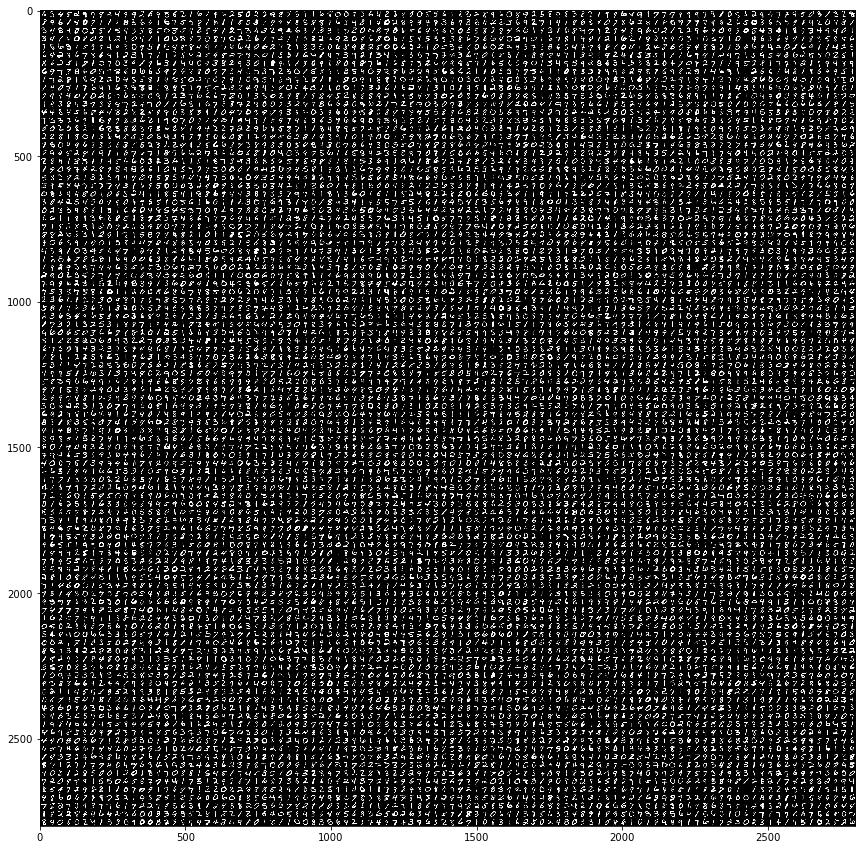

In [67]:
plt.figure(figsize=(15,15))
plt.imshow(atlas)

In [47]:
# x_test, y_test = mnist.test.next_batch(10000)
# x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1) # Reverse one hot
y_test = np.argmax(y_test, axis=1)

In [70]:
df = pd.DataFrame({"prediction": predictions, "actual": y_test})

In [49]:
jsonstr = df.to_json(orient='records')

In [71]:
# Display the Dive visualization for this data
from IPython.core.display import display, HTML

HTML_TEMPLATE = """
        <head>
        <link rel="import" href="./facets-jupyter.html"></link>
        </head>
        <facets-dive id="elem" height="800" sprite-image-width="28" sprite-image-height="28" atlas-url="atlas.jpg"></facets-dive>
        <script>
          var data = JSON.parse('{jsonstr}');
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))